# Data modeling

This notebook is to model the data to derive any trends


# two types of analysis will be ran
1. LOG Regression (On lOS)
2. Random Forest Classification (On Death_flag)

In [1]:
#Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import shap

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score,roc_curve, confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay



In [2]:
#Load Datasets


#Demographics mixed with care dataset. Used for reference
demo_care=pd.read_csv('../data/Final Data/demo_care.csv')

#Demographics mixed with care dataset cleaned
demo_care_clean=pd.read_csv('../data/Final Data/demo_care_clean.csv')

# Test Dataset
test=pd.read_csv('../data/Final Data/test_dataset.csv')

# Train Dataset
train=pd.read_csv('../data/Final Data/train_dataset.csv')

# Validation Dataset
validation=pd.read_csv('../data/Final Data/validation_dataset.csv')

In [3]:
demo_care

,subject_id,stay_id,first_careunit,los,gender,anchor_age,anchor_year_group,death_flag,insurance,language,...,has_cardiac_issues,num_diagnoses,num_procedures,num_drugs,readmission_flag,icu_type_encoded,mortality_rate_by_unit,age_capped,age_group,log_los
0,10018328,31269608,neuro stepdown,7.702512,0,83,1,0,4,1,...,1,25,2,48,0,5,0.000000,83,2,2.163612
1,10020187,37509585,neuro surgical intensive care unit (neuro sicu),5.452662,0,63,1,0,4,0,...,1,12,1,30,1,6,0.333333,63,1,1.864493
2,10020187,32554129,neuro intermediate,0.872685,0,63,1,0,4,0,...,1,12,1,30,1,4,0.000000,63,1,0.627373
3,10012853,31338022,trauma sicu (tsicu),3.766725,0,91,1,0,1,1,...,1,66,1,52,0,8,0.312500,90,0,1.561659
4,10020740,32145159,trauma sicu (tsicu),1.037106,1,56,1,0,4,1,...,1,44,13,82,1,8,0.312500,56,1,0.711530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,10023239,33846653,medical/surgical intensive care unit (micu/sicu),2.825370,0,29,1,0,4,1,...,0,29,3,50,1,3,0.400000,29,4,1.341655
127,10023239,35024147,medical/surgical intensive care unit (micu/sicu),2.432998,0,29,1,0,4,1,...,0,29,3,50,1,3,0.400000,29,4,1.233434
128,10001725,31205490,medical/surgical intensive care unit (micu/sicu),1.338588,0,46,0,0,4,1,...,0,18,3,35,0,3,0.400000,46,1,0.849547
129,10035631,30932571,medical/surgical intensive care unit (micu/sicu),10.494259,1,63,0,1,4,1,...,1,101,21,176,0,3,0.400000,63,1,2.441848


In [4]:
#splitting training dataset. Needs to be done for analysis. I want to have one where 

In [5]:
print("Test shape", test.shape)
print("Train shape", train.shape)
print("validation shape", validation.shape)
train.head()

Test shape (27, 23)
Train shape (78, 23)
validation shape (26, 23)


,los,gender,anchor_year_group,death_flag,insurance,language,marital_status,race,is_elderly,los_hours,...,has_cardiac_issues,num_diagnoses,num_procedures,num_drugs,readmission_flag,icu_type_encoded,mortality_rate_by_unit,age_capped,age_group,log_los
0,13.899225,1,0,1,2,1,4,15,True,333.581389,...,1,58,14,90,1,8,0.312500,79,3,2.701309
1,0.898449,0,1,0,0,0,4,5,False,21.562778,...,0,10,2,28,0,0,0.086957,63,1,0.641037
2,7.446424,1,1,0,4,1,6,15,False,178.714167,...,1,44,13,82,1,3,0.400000,56,1,2.133743
3,1.487245,1,1,0,4,1,4,15,False,35.693889,...,1,12,4,56,0,0,0.086957,62,1,0.911176
4,15.972812,1,1,1,2,1,4,15,True,383.347500,...,1,51,9,102,1,2,0.538462,66,3,2.831613


In [6]:
# Regression Target
target_los='log_los'

# Classification target:
target_mort='death_flag'

In [7]:
# Dropping targets and unique ids

drop_cols=['los_hours','los','long_stay_flag','death_within_24h_flag',target_los,target_mort]

# Dropping columns in each dataset

#Training
X_train=train.drop(columns=drop_cols,errors='ignore')
y_train_los=train[target_los]
y_train_mort=train[target_mort]

# Val

X_val=validation.drop(columns=drop_cols,errors='ignore')
y_val_los=validation[target_los]
y_val_mort=validation[target_mort]

#Test
X_test=test.drop(columns=drop_cols,errors='ignore')
y_test_los=test[target_los]
y_test_mort=test[target_mort]

# LOS

## OLS (LOS)

In [8]:
ols=LinearRegression()
ols.fit(X_train,y_train_los)

y_pred_val_ols=ols.predict(X_val)
y_pred_test_ols=ols.predict(X_test)


print("\nOLS Validation Results")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_val_los, y_pred_val_ols)):.2f}")
print(f"Linear Regression R^2: {r2_score(y_val_los, y_pred_val_ols):.2f}")

print("\nOLS test Results")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test_los, y_pred_test_ols)):.2f}")
print(f"Linear Regression R^2: {r2_score(y_test_los, y_pred_test_ols):.2f}")



OLS Validation Results
Linear Regression RMSE: 0.72
Linear Regression R^2: 0.05

OLS test Results
Linear Regression RMSE: 0.65
Linear Regression R^2: 0.14


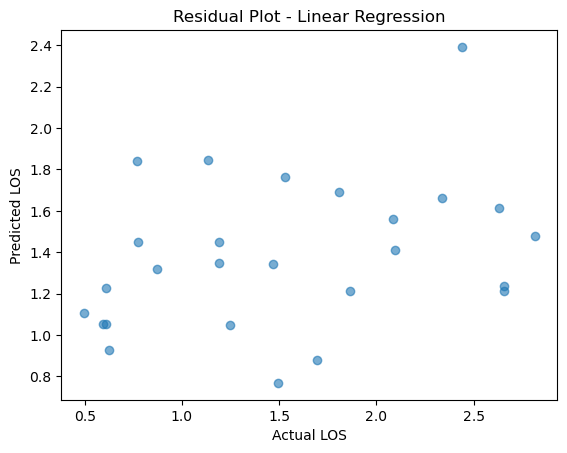

In [9]:
plt.scatter(y_val_los, y_pred_val_ols, alpha=0.6)
plt.xlabel("Actual LOS")
plt.ylabel("Predicted LOS")
plt.title("Residual Plot - Linear Regression")
plt.show()


## Lasso (LOS)

In [10]:
lasso= Lasso(max_iter=5000)

lasso_params={'alpha':np.logspace(-3,1,20)}
grid_lasso=GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train_los)

best_lasso=grid_lasso.best_estimator_
#Validation
y_pred_val_lasso=best_lasso.predict(X_val)
#Test
y_pred_test_lasso=best_lasso.predict(X_test)

print("\nLasso Regression Results (Val)")
print(f"Lasso R^2: {r2_score(y_val_los, y_pred_val_lasso):.2f}")

print("\nLasso Regression Results")
print(f"Best Alpha : {grid_lasso.best_params_['alpha']}")
print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_test_los, y_pred_test_lasso)):.2f}")
print(f"Lasso R^2: {r2_score(y_test_los, y_pred_test_lasso):.2f}")


Lasso Regression Results (Val)
Lasso R^2: 0.01

Lasso Regression Results
Best Alpha : 1.438449888287663
Lasso RMSE: 0.64
Lasso R^2: 0.18


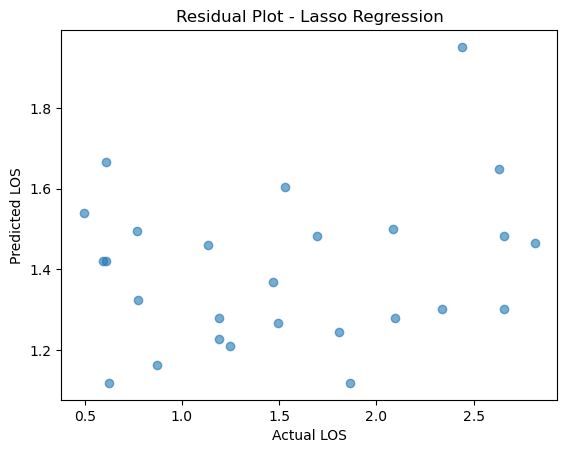

In [11]:
plt.scatter(y_val_los, y_pred_val_lasso, alpha=0.6)
plt.xlabel("Actual LOS")
plt.ylabel("Predicted LOS")
plt.title("Residual Plot - Lasso Regression")
plt.show()


In [12]:
lasso_coef=pd.Series(best_lasso.coef_, index=X_train.columns)
print("\nTop Features Selected by Lasso:")
print(lasso_coef[lasso_coef !=0].sort_values(ascending=False).head(10))


Top Features Selected by Lasso:
num_drugs    0.005706
dtype: float64


## Ridge (LOS)

In [13]:
ridge=Ridge(max_iter=5000)
ridge_params={'alpha':np.logspace(-3,3,20)}

grid_ridge=GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train_los)

best_ridge= grid_ridge.best_estimator_

# Val
y_pred_val_ridge=best_ridge.predict(X_val)
#Test
y_pred_test_ridge=best_ridge.predict(X_test)

print("\nRidge Regression Results")
print(f"Best Alpha : {grid_ridge.best_params_['alpha']}")
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_test_los, y_pred_test_ridge)):.2f}")
print(f"Ridge R^2: {r2_score(y_test_los, y_pred_test_ridge):.2f}")


Ridge Regression Results
Best Alpha : 1000.0
Ridge RMSE: 0.61
Ridge R^2: 0.25


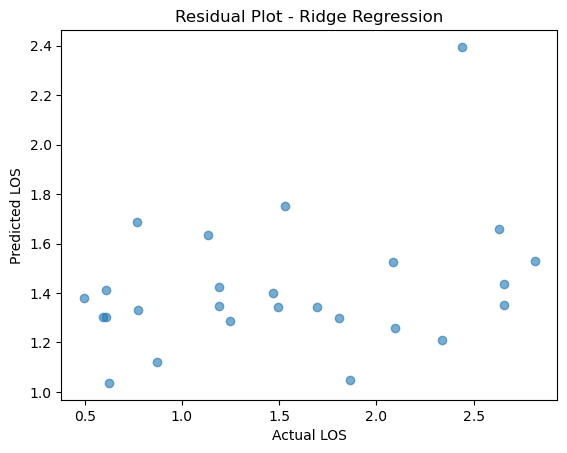

In [14]:
plt.scatter(y_val_los, y_pred_val_ridge, alpha=0.6)
plt.xlabel("Actual LOS")
plt.ylabel("Predicted LOS")
plt.title("Residual Plot - Ridge Regression")
plt.show()


## Random Forest Regressor (LOS)

In [15]:
rf_reg = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None
)
rf_reg.fit(X_train, y_train_los)

y_pred_val_rf = rf_reg.predict(X_val)
y_pred_test_rf = rf_reg.predict(X_test)


# Validation
print(f"Random forest R^2: {r2_score(y_val_los, y_pred_val_rf):.2f}")

#Test 
print("\nRandom forest Results")
print(f"Random forest RMSE: {np.sqrt(mean_squared_error(y_test_los, y_pred_test_rf)):.2f}")
print(f"Random Forest R^2: {r2_score(y_test_los, y_pred_test_rf):.2f}")

Random forest R^2: -0.16

Random forest Results
Random forest RMSE: 0.54
Random Forest R^2: 0.43


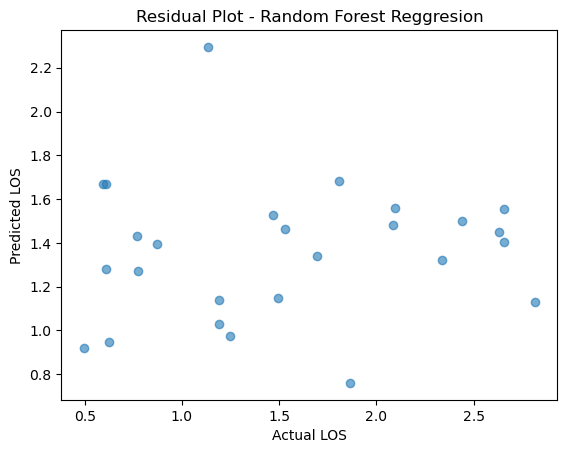

In [16]:
plt.scatter(y_val_los, y_pred_val_rf, alpha=0.6)
plt.xlabel("Actual LOS")
plt.ylabel("Predicted LOS")
plt.title("Residual Plot - Random Forest Reggresion")
plt.show()


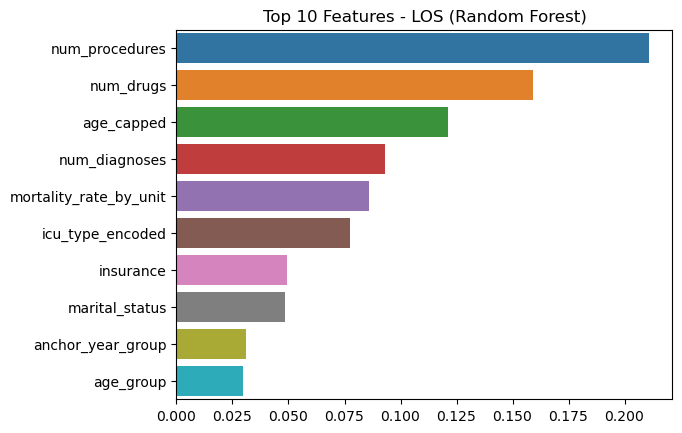

In [17]:
importances_rf_los = pd.Series(rf_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=importances_rf_los[:10], y=importances_rf_los.index[:10])
plt.title("Top 10 Features - LOS (Random Forest)")
plt.show()


In [18]:
# LOS Comp

los_results =pd.DataFrame({
    'Model':['Ols','Lasso','Ridge','Random Forest'],
    'test_rmse':[np.sqrt(mean_squared_error(y_test_los,y_pred_test_ols)),
                np.sqrt(mean_squared_error(y_test_los,y_pred_test_lasso)),
                np.sqrt(mean_squared_error(y_test_los,y_pred_test_ridge)),
                np.sqrt(mean_squared_error(y_test_los,y_pred_test_rf))],
    'test_R2':[r2_score(y_test_los,y_pred_test_ols),
              r2_score(y_test_los,y_pred_test_lasso),
              r2_score(y_test_los,y_pred_test_ridge),
              r2_score(y_test_los,y_pred_test_rf)]
})


print("\n Model Comparision (Log_LOS)")
print(los_results)



 Model Comparision (Log_LOS)
           Model  test_rmse   test_R2
0            Ols   0.653482  0.143839
1          Lasso   0.638474  0.182715
2          Ridge   0.610552  0.252635
3  Random Forest   0.535301  0.425509


# Mortality Models

In [19]:
log_model = LogisticRegression(max_iter=5000, class_weight='balanced')
log_model.fit(X_train, y_train_mort)

y_pred_proba=log_model.predict_proba(X_val)[:,1]
roc_auc=roc_auc_score(y_val_mort,y_pred_proba)
print(f"Logistic Regression ROC-AUC: {roc_auc:.3f}")

Logistic Regression ROC-AUC: 0.601


In [20]:
odds_ratios=np.ratios=np.exp(log_model.coef_[0])
coeff_table=pd.DataFrame({'Feature':X_train.columns,
                         'Odds_ratio':odds_ratios}).sort_values(by='Odds_ratio', ascending=False)
coeff_table.head(10)

,Feature,Odds_ratio
14,mortality_rate_by_unit,2.922963
0,gender,2.630937
12,readmission_flag,2.291594
6,is_elderly,1.726876
8,has_cardiac_issues,1.221793
16,age_group,1.211199
5,race,1.110545
13,icu_type_encoded,1.087534
11,num_drugs,1.019205
9,num_diagnoses,1.016076


<function matplotlib.pyplot.show(close=None, block=None)>

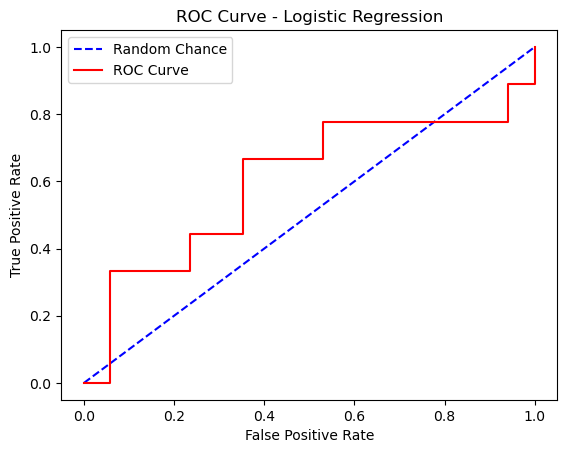

In [34]:
fpr, tpr, _ = roc_curve(y_val_mort, y_pred_proba)
plt.plot([0,1], [0,1], '--', color='blue', label='Random Chance')
plt.plot(fpr, tpr, color='red', label='ROC Curve') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show

In [22]:
rf_clf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)
rf_clf.fit(X_train, y_train_mort)

y_pred_proba_rf = rf_clf.predict_proba(X_val)[:,1]
roc_auc_rf=roc_auc_score(y_val_mort,y_pred_proba_rf)
print(f"Random forest ROC-AUC: {roc_auc_rf:.3f}")

Random forest ROC-AUC: 0.814


In [23]:
threshold = 0.5
y_pred_class_rf=(y_pred_proba_rf >= threshold).astype(int)

In [24]:
cm=confusion_matrix(y_val_mort,y_pred_class_rf)
print(cm)

[[15  2]
 [ 3  6]]


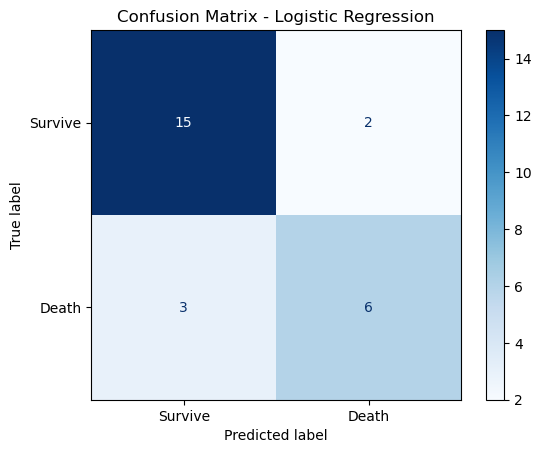

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Survive', 'Death'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


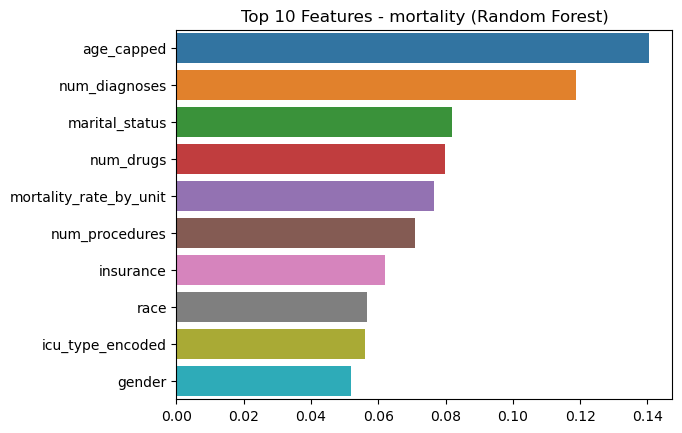

In [26]:
importances_rf_mort = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=importances_rf_mort[:10], y=importances_rf_mort.index[:10])
plt.title("Top 10 Features - mortality (Random Forest)")
plt.show()


In [27]:
top_los = set(importances_rf_los.head(10).index)
top_mort=set(importances_rf_mort.head(10).index)

shared=top_los.intersection(top_mort)

print("features that affect both LOS and Mortality")
for feat in shared:
    print("-", feat)

features that affect both LOS and Mortality
- marital_status
- num_drugs
- num_procedures
- mortality_rate_by_unit
- num_diagnoses
- insurance
- age_capped
- icu_type_encoded


# Deeper analysis on shared features

Will dive into deeper analysis on the features that are shared between LOS and Mortality

- insurance
- marital_status
- num_drugs
- num_diagnoses
- num_procedures
- age_capped
- mortality_rate_by_unit
- icu_type_encoded

This is where the pvalue and confidence intervals will be tested

In [28]:
shared=['insurance','marital_status','num_drugs','num_diagnoses','num_procedures','age_capped',
        'mortality_rate_by_unit','icu_type_encoded']

#### LOS Regression

In [29]:
X_train_const=sm.add_constant(X_train[shared])

ols_model=sm.OLS(y_train_los, X_train_const).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_los   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     2.395
Date:                Sun, 26 Oct 2025   Prob (F-statistic):             0.0242
Time:                        19:07:32   Log-Likelihood:                -64.285
No. Observations:                  78   AIC:                             146.6
Df Residuals:                      69   BIC:                             167.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

The nummber of drugs is the only variable that is statistically significant at a 95% confience level.

#### Mortality Classification

In [30]:
logit_model=sm.Logit(y_train_mort,sm.add_constant(X_train[shared])).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.493475
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             death_flag   No. Observations:                   78
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            8
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.2350
Time:                        19:07:32   Log-Likelihood:                -38.491
converged:                       True   LL-Null:                       -50.313
Covariance Type:            nonrobust   LLR p-value:                  0.002630
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.0233      2.563     -2.740      0.006     -12.047      

In [31]:
params = logit_model.params
conf = logit_model.conf_int()
odds_ratios = pd.DataFrame({
    'OR': np.exp(params),
    '2.5%': np.exp(conf[0]),
    '97.5%': np.exp(conf[1]),
    'p-value': logit_model.pvalues
})
print(odds_ratios.sort_values(by='p-value'))


                                 OR       2.5%          97.5%   p-value
mortality_rate_by_unit  1638.037984  10.170796  263811.050043  0.004309
const                      0.000891   0.000006       0.135372  0.006141
age_capped                 1.051693   1.005993       1.099470  0.026176
num_drugs                  1.062402   1.004225       1.123949  0.035143
num_procedures             0.826222   0.681413       1.001803  0.052181
num_diagnoses              0.974142   0.936435       1.013368  0.193375
insurance                  0.768903   0.492460       1.200529  0.247681
icu_type_encoded           1.114165   0.888041       1.397867  0.350278
marital_status             0.890491   0.684209       1.158965  0.388321


The number of drugs and age are related to higher mortality